In [1]:
%load_ext autoreload
%autoreload 2

import os
from itertools import count

import contextily as cx
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import geopandas
import osmnx as ox
import pandas as pd
from tqdm.auto import tqdm
from libpysal.cg import voronoi_frames

import shapely
shapely.speedups.disable()

DATA = "data"

In [2]:
# Wrocław coordinates
latitude = 51.11
longitude =  17.022222

max_dist_km = 18
max_dist = max_dist_km * 1000

## Dane z OSM

### Drive type

c:\users\wojte\.pyenv\pyenv-win\versions\3.6.8\lib\site-packages\osmnx\utils_geo.py:335: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
c:\users\wojte\.pyenv\pyenv-win\versions\3.6.8\lib\site-packages\osmnx\utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
c:\users\wojte\.pyenv\pyenv-win\versions\3.6.8\lib\site-packages\osmnx\utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


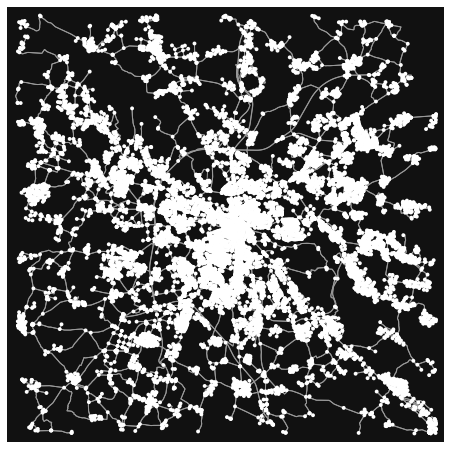

In [3]:
G_drive = ox.graph_from_point((latitude, longitude), dist=max_dist, network_type="drive")
fig, ax = ox.plot_graph(G_drive)

In [6]:
nx.write_gpickle(G_drive, os.path.join(DATA, "peripheral_drive_network.gpickle"))

# save street network as GeoPackage to work with in GIS
ox.save_graph_geopackage(G_drive, filepath=os.path.join(DATA, "peripheral_drive_network.gpkg"))

# save street network as GraphML file to work with later in OSMnx or networkx or gephi
ox.save_graphml(G_drive, filepath=os.path.join(DATA, "peripheral_drive_network.graphml"))

### Bike type

c:\users\wojte\.pyenv\pyenv-win\versions\3.6.8\lib\site-packages\osmnx\utils_geo.py:335: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
c:\users\wojte\.pyenv\pyenv-win\versions\3.6.8\lib\site-packages\osmnx\utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
c:\users\wojte\.pyenv\pyenv-win\versions\3.6.8\lib\site-packages\osmnx\utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


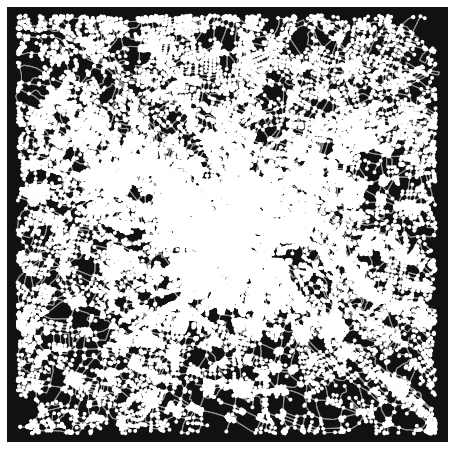

In [7]:
G_bike = ox.graph_from_point((latitude, longitude), dist=max_dist, network_type="bike")
fig, ax = ox.plot_graph(G_bike)

In [8]:
nx.write_gpickle(G_bike, os.path.join(DATA, "peripheral_bike_network.gpickle"))

# save street network as GeoPackage to work with in GIS
ox.save_graph_geopackage(G_bike, filepath=os.path.join(DATA, "peripheral_bike_network.gpkg"))

# save street network as GraphML file to work with later in OSMnx or networkx or gephi
ox.save_graphml(G_bike, filepath=os.path.join(DATA, "peripheral_bike_network.graphml"))

In [9]:
G_drive_nodes = list(G_drive.nodes)
G_bike_nodes = list(G_bike.nodes)
common_nodes = list(set(G_drive_nodes).intersection(G_bike_nodes))

In [10]:
G_only_bike = G_bike.copy()
for n in common_nodes:
    G_only_bike.remove_node(n)

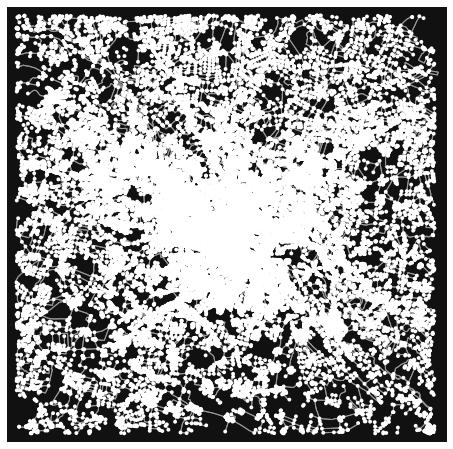

In [11]:
fig, ax = ox.plot_graph(G_only_bike)

In [12]:
nx.write_gpickle(G_only_bike, os.path.join(DATA, "only_bike.gpickle"))

# save street network as GeoPackage to work with in GIS
ox.save_graph_geopackage(G_only_bike, filepath=os.path.join(DATA, "only_bike.gpkg"))

# save street network as GraphML file to work with later in OSMnx or networkx or gephi
ox.save_graphml(G_only_bike, filepath=os.path.join(DATA, "only_bike.graphml"))

## Połączenie z Inwestmapą

Dane z csv

In [13]:
investmap_gdf = geopandas.read_file(os.path.join(DATA, "investmap.csv"))
investmap_gdf["Longitude"] = investmap_gdf["Longitude"].apply(lambda x: float(x))
investmap_gdf["Latitude"] = investmap_gdf["Latitude"].apply(lambda x: float(x))
investmap_gdf["geometry"] = geopandas.points_from_xy(investmap_gdf["Longitude"], investmap_gdf["Latitude"])
investmap_gdf = investmap_gdf.set_crs(epsg=4326)

c:\users\wojte\.pyenv\pyenv-win\versions\3.6.8\lib\site-packages\geopandas\geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Dane rowerowe z gpkg dla geopandas

In [14]:
bike_gdf = geopandas.read_file(os.path.join(DATA, "peripheral_bike_network.gpkg"))
bike_gdf = bike_gdf.to_crs(epsg=4326)

c:\users\wojte\.pyenv\pyenv-win\versions\3.6.8\lib\site-packages\geopandas\geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Filtracja danych z inwestamapy

In [15]:
x_min = bike_gdf.x.min()
x_max = bike_gdf.x.max()
y_min = bike_gdf.y.min()
y_max = bike_gdf.y.max()
x_min, x_max, y_min, y_max

(16.764401, 17.2800532, 50.9481225, 51.2718636)

In [16]:
investmap_gdf = investmap_gdf[(x_min < investmap_gdf.Longitude) & (investmap_gdf.Longitude < x_max) &
                              (y_min < investmap_gdf.Latitude) & (investmap_gdf.Latitude < y_max)]

In [17]:
len(investmap_gdf)

1481

Wczytanie grafu "rowerowego"

In [22]:
G = nx.read_gpickle(os.path.join(DATA, "peripheral_bike_network.gpickle"))

In [23]:
for n in G.nodes:
    G.nodes[n]["type"]="crossing"
    
nx.set_edge_attributes(G, "bicycle_path", "type")

In [24]:
i = investmap_gdf.to_crs(epsg=2177) #Poland epsg
b = bike_gdf.to_crs(epsg=2177)

Dodanie wierzchołków z inwestmapy

In [25]:
for j, (p_ind, p) in tqdm(enumerate(i.iterrows()), total=i.shape[0]):
    distance=b.distance(p["geometry"])
    idx = distance.idxmin()
    min_d = distance.min()
    node = f'{p["Id"]}_building'
    G.add_nodes_from([(node, {'type': 'building', 'name': p["Title"], 'y': p["Latitude"], 'x': p["Longitude"]})])
    G.add_edge(bike_gdf.iloc[idx]["osmid"], node, length=min_d, type="closest_crossing")

  0%|          | 0/1481 [00:00<?, ?it/s]

Zapisanie całego grafu

In [26]:
nx.write_gpickle(G, os.path.join(DATA, "peripheral_bike_and_investmap.gpickle"))

### Wizualizacja

In [48]:
G = nx.read_gpickle(os.path.join(DATA, "peripheral_bike_and_investmap.gpickle"))

In [49]:
G_nodes, G_streets = ox.graph_to_gdfs(G)

G_nodes = G_nodes.to_crs(epsg=2177)
G_streets = G_streets.to_crs(epsg=2177)

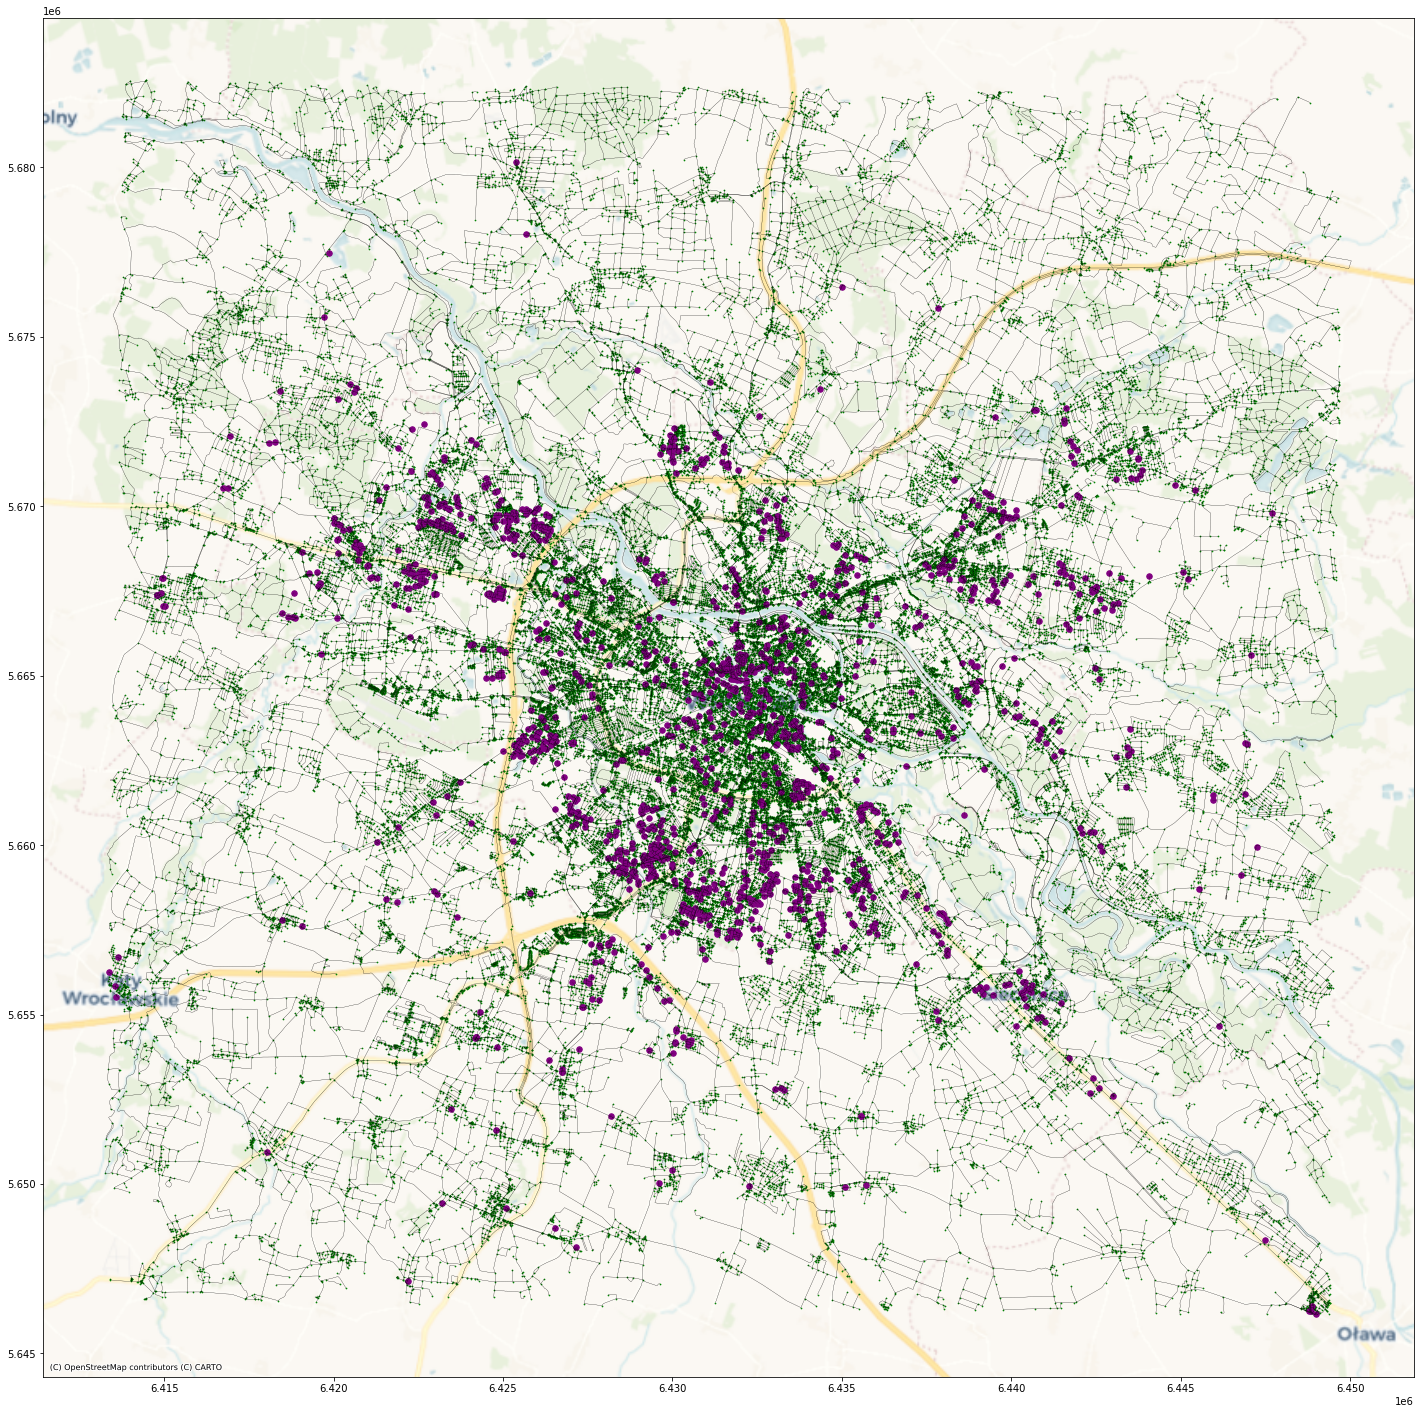

In [50]:
fig = plt.figure(figsize=(25,25))
ax = plt.subplot()

G_nodes[G_nodes['type'] == 'crossing'].plot(markersize=0.5, color='green', ax=ax)
G_nodes[G_nodes['type'] == 'building'].plot(markersize=30, color='purple', ax=ax)
G_streets.plot(ax=ax, alpha=0.7, linewidth=0.2, edgecolor='k')
cx.add_basemap(ax=ax, crs=G_nodes.crs.to_string(), source=cx.providers.CartoDB.Voyager)

In [51]:
fig.savefig('image\peripheral_bike_and_investmap.png', bbox_inches='tight')
fig.savefig('image\peripheral_bike_and_investmap_dpi200.png', bbox_inches='tight', dpi=200)

## Połączenie z Inwestmapą (tylko rowerowe)

In [33]:
investmap_gdf = geopandas.read_file(os.path.join(DATA, "investmap.csv"))
investmap_gdf["Longitude"] = investmap_gdf["Longitude"].apply(lambda x: float(x))
investmap_gdf["Latitude"] = investmap_gdf["Latitude"].apply(lambda x: float(x))
investmap_gdf["geometry"] = geopandas.points_from_xy(investmap_gdf["Longitude"], investmap_gdf["Latitude"])
investmap_gdf = investmap_gdf.set_crs(epsg=4326)

c:\users\wojte\.pyenv\pyenv-win\versions\3.6.8\lib\site-packages\geopandas\geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Dane rowerowe z gpkg dla geopandas

In [34]:
bike_gdf = geopandas.read_file(os.path.join(DATA, "only_bike.gpkg"))
bike_gdf = bike_gdf.to_crs(epsg=4326)

c:\users\wojte\.pyenv\pyenv-win\versions\3.6.8\lib\site-packages\geopandas\geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Filtracja danych z inwestamapy

In [35]:
x_min = bike_gdf.x.min()
x_max = bike_gdf.x.max()
y_min = bike_gdf.y.min()
y_max = bike_gdf.y.max()
x_min, x_max, y_min, y_max

(16.764401, 17.2800422, 50.9481225, 51.2718636)

In [36]:
investmap_gdf = investmap_gdf[(x_min < investmap_gdf.Longitude) & (investmap_gdf.Longitude < x_max) &
                              (y_min < investmap_gdf.Latitude) & (investmap_gdf.Latitude < y_max)]

In [37]:
len(investmap_gdf)

1481

Wczytanie grafu "rowerowego"

In [38]:
G = nx.read_gpickle(os.path.join(DATA, "only_bike.gpickle"))

In [39]:
for n in G.nodes:
    G.nodes[n]["type"]="crossing"
    
nx.set_edge_attributes(G, "bicycle_path", "type")

In [40]:
i = investmap_gdf.to_crs(epsg=2177) #Poland epsg
b = bike_gdf.to_crs(epsg=2177)

Dodanie wierzchołków z inwestmapy

In [41]:
for j, (p_ind, p) in tqdm(enumerate(i.iterrows()), total=i.shape[0]):
    distance=b.distance(p["geometry"])
    idx = distance.idxmin()
    min_d = distance.min()
    node = f'{p["Id"]}_building'
    G.add_nodes_from([(node, {'type': 'building', 'name': p["Title"], 'y': p["Latitude"], 'x': p["Longitude"]})])
    G.add_edge(bike_gdf.iloc[idx]["osmid"], node, length=min_d, type="closest_crossing")

  0%|          | 0/1481 [00:00<?, ?it/s]

Zapisanie całego grafu

In [42]:
nx.write_gpickle(G, os.path.join(DATA, "only_bike_and_investmap.gpickle"))

### Wizualizacja

In [43]:
G = nx.read_gpickle(os.path.join(DATA, "only_bike_and_investmap.gpickle"))

In [44]:
G_nodes, G_streets = ox.graph_to_gdfs(G)

G_nodes = G_nodes.to_crs(epsg=2177)
G_streets = G_streets.to_crs(epsg=2177)

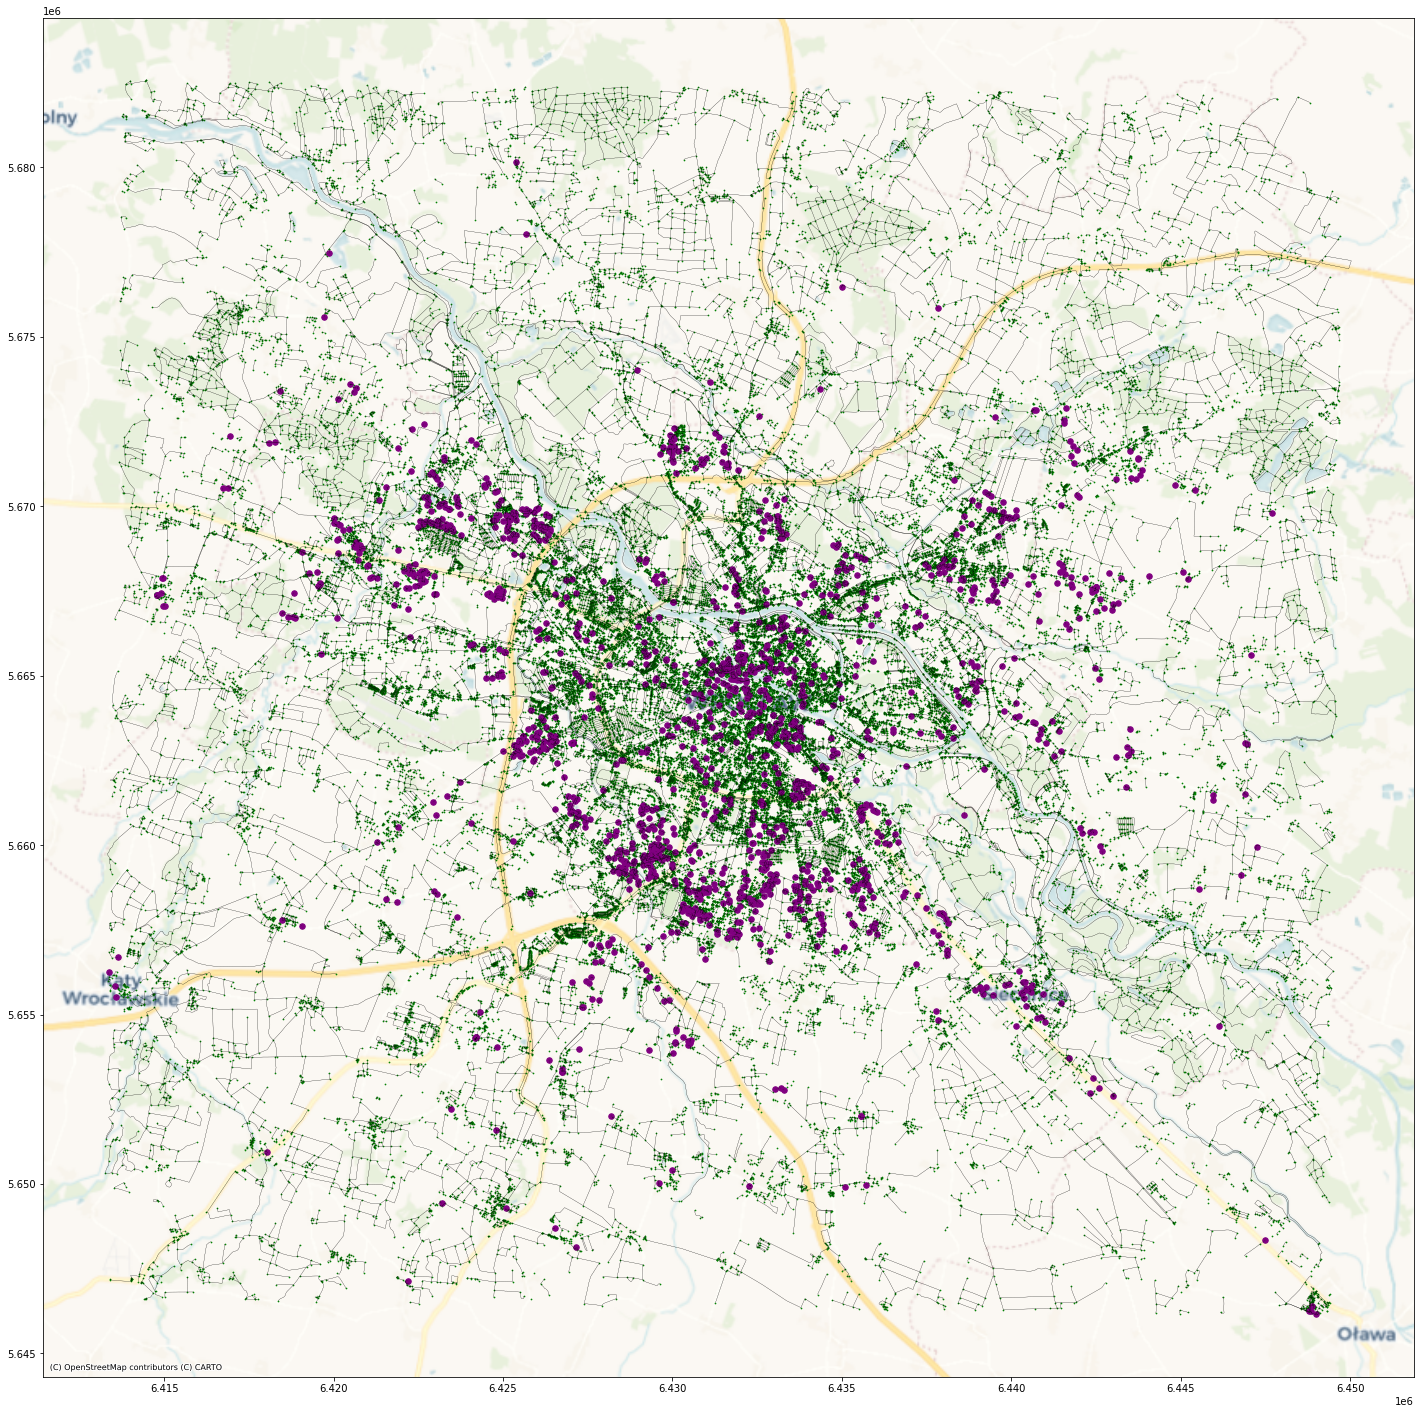

In [45]:
fig = plt.figure(figsize=(25,25))
ax = plt.subplot()

G_nodes[G_nodes['type'] == 'crossing'].plot(markersize=0.5, color='green', ax=ax)
G_nodes[G_nodes['type'] == 'building'].plot(markersize=30, color='purple', ax=ax)
G_streets.plot(ax=ax, alpha=0.7, linewidth=0.2, edgecolor='k')
cx.add_basemap(ax=ax, crs=G_nodes.crs.to_string(), source=cx.providers.CartoDB.Voyager)

In [47]:
fig.savefig('image\only_bike_and_investmap.png', bbox_inches='tight')
fig.savefig('image\only_bike_and_investmap_dpi200.png', bbox_inches='tight', dpi=200)